# Average firing rate analysis
Assesses data from neuropixels recordings

In [256]:
# imports 
import numpy as np 
import pandas as pd 
import h5py
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from pathlib import Path
from matplotlib_venn import venn3
import matplotlib.colors as mcolors
import warnings
import pingouin as pg
from sklearn.linear_model import LinearRegression
import seaborn as sns
import os
import glob
import random

 
warnings.filterwarnings("ignore", message="Mean of empty slice", category=RuntimeWarning)

In [257]:
# functions
def get_labelled_posteriors(indata, labels):

    '''
    INPUTS:
    indata = posterior probabilites from a classifier with the shape
            n_trials x n_timesteps x n_classes
        
    labels = 1d array with len(n_trials) - these labels ought
            to correspond to class numbers (layers in indata)

    OUTPUT:
        labelled_posteriors = posterior probabilities associated with the
        classes in the labels input for each timestep and trial
    '''

    n_trials, n_times, n_classes = indata.shape
    class_lbls = np.unique(labels)
    class_lbls = class_lbls[~np.isnan(class_lbls)]

    # initialize output
    labelled_posteriors = np.zeros(shape = (n_trials, n_times))

    for ix, lbl in enumerate(class_lbls):
        
        # find trials where this label was chosen
        labelled_posteriors[labels == lbl,:] = indata[labels == lbl,:,int(ix)]
        
    return labelled_posteriors


def pull_balanced_train_set(trials2balance, params2balance):
    '''
    INPUTS:
    trials2balance   - ***logical array*** of the trials you want to balance
    params2balance   - ***list*** where each element is a vector of categorical
                        parameters to balance (e.g. choice value and side)
                        each element of params2balance must have the same
                        number of elements as trials2balance
    OUTPUTS:
    train_ix         - trial indices of a fully balanced training set
    leftover_ix      - trial indices of trials not included in train_ix
    '''

    # Find the indices where trials are selected to balance
    balance_indices = np.where(trials2balance)[0]

    # Create an array of parameters to balance
    params_array = np.array(params2balance).T

    # Find unique combinations and their counts
    p_combos, p_counts = np.unique(params_array[balance_indices], axis=0, return_counts=True)

    # Determine the minimum count for a balanced set
    n_to_keep = np.min(p_counts)

    # Initialize arrays to mark selected and leftover trials
    train_ix = np.zeros(len(trials2balance), dtype=bool)
    leftover_ix = np.zeros(len(trials2balance), dtype=bool)

    # Select a balanced number of trials for each unique parameter combination
    for combo in p_combos:
        # Find indices of trials corresponding to the current combination
        combo_indices = np.where((params_array == combo).all(axis=1) & trials2balance)[0]

        # Shuffle the indices
        np.random.shuffle(combo_indices)

        # Select n_to_keep trials and mark them as part of the training set
        train_ix[combo_indices[:n_to_keep]] = True

        # Mark the remaining trials as leftovers
        leftover_ix[combo_indices[n_to_keep:]] = True

    return train_ix, leftover_ix


def random_prop_of_array(inarray, proportion):
    '''
    INPUTS
    inarray = logical/boolean array of indices to potentially use later
    proportion = how much of inarray should randomly be selected

    OUTPUT
    out_array = logical/boolean that's set as 'true' for a proportion of the 
                initial 'true' values in inarray
    '''

    out_array = np.zeros(shape = (len(inarray), ))

    # find where inarray is true and shuffle those indices
    shuffled_ixs = np.random.permutation(np.asarray(np.where(inarray)).flatten())

    # keep only a proportion of that array
    kept_ix = shuffled_ixs[0: round(len(shuffled_ixs)*proportion)]

    # fill in the kept indices
    out_array[kept_ix] = 1

    # make this a logical/boolean
    out_array = out_array > 0

    return out_array

def find_h5_files(directory):
    """
    Search for HDF5 files (.h5 extension) in the specified directory.

    Parameters:
    - directory (str): Path to the directory to search for HDF5 files.

    Returns:
    - List[str]: A list of filenames (including paths) of HDF5 files found in the directory.
    """
    h5_files = []
    search_pattern = os.path.join(directory, '*.h5')  # Pattern to search for .h5 files

    for file_path in glob.glob(search_pattern):
        if os.path.isfile(file_path):
            h5_files.append(file_path)

    return h5_files

def pull_from_h5(file_path, data_to_extract):
    try:
        with h5py.File(file_path, 'r') as file:
            # Check if the data_to_extract exists in the HDF5 file
            if data_to_extract in file:
                data = file[data_to_extract][...]  # Extract the data
                return data
            else:
                print(f"'{data_to_extract}' not found in the file.")
                return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None
    
def list_hdf5_data(file_path):
    try:
        with h5py.File(file_path, 'r') as file:
            print(f"Datasets in '{file_path}':")
            for dataset in file:
                print(dataset)
    except Exception as e:
        print(f"An error occurred: {e}")


def get_ch_and_unch_vals(bhv):
    """
    Extracts chosen (ch_val) and unchosen (unch_val) values associated with each trial.

    Parameters:
    - bhv (DataFrame): DataFrame behavioral data.

    Returns:
    - ch_val (ndarray): Array of chosen values for each trial.
    - unch_val (ndarray): Array of unchosen values for each trial. 
                          - places 0s for unchosen values on forced choice trials
    """
    ch_val = np.zeros(shape=(len(bhv, )))
    unch_val = np.zeros(shape=(len(bhv, )))

    bhv['r_val'] = bhv['r_val'].fillna(0)
    bhv['l_val'] = bhv['l_val'].fillna(0)

    ch_left = bhv['side'] == -1
    ch_right = bhv['side'] == 1

    ch_val[ch_left] = bhv['l_val'].loc[ch_left].astype(int)
    ch_val[ch_right] = bhv['r_val'].loc[ch_right].astype(int)

    unch_val[ch_left] = bhv['r_val'].loc[ch_left].astype(int)
    unch_val[ch_right] = bhv['l_val'].loc[ch_right].astype(int)

    return ch_val, unch_val


def get_ch_and_unch_pps(in_pp, bhv, ch_val, unch_val):
    """Gets the posteriors associated with the chosen and unchosen classes

    Args:
        in_pp (ndarray): array of posteriors (n_trials x n_times x n_classes)
        bhv (dataframe): details of each trial
        ch_val (ndarray): vector indicating the class that is ultimately chosen
        unch_val (ndarray): vector indicating the class that was ultimately not chosen

    Returns:
        ch_pp (ndarray): vector of the postior at each point in time for each trial's chosen option
        unch_pp (ndarray): vector of the postior at each point in time for each trial's unchosen option
    """

    # select the chosen and unchosen values 
    n_trials, n_times, n_classes = np.shape(in_pp)
    ch_pp = np.zeros(shape=(n_trials, n_times))
    unch_pp = np.zeros(shape=(n_trials, n_times))

    # loop over each trial
    for t in range(n_trials):
        
        # get the chosen and unchosen PPs
        ch_pp[t, :] = in_pp[t, :, int(ch_val[t]-1)]
        unch_pp[t, :] = in_pp[t, :, int(unch_val[t]-1)]
        
    # set the forced choice unchosen pps to nans, since there was only 1 option
    unch_pp[bhv['forced'] == 1, :] = np.nan
    
    return ch_pp, unch_pp


def get_alt_ch_and_unch_pps(in_pp, bhv, s_ch_val, s_unch_val):
    """Gets the posteriors associated with the chosen and unchosen classes

    Args:
        in_pp (ndarray): array of posteriors (n_trials x n_times x n_classes)
        bhv (dataframe): details of each trial
        s_ch_val (ndarray): vector indicating the class that is ultimately chosen
        s_unch_val (ndarray): vector indicating the class that was ultimately not chosen

    Returns:
        alt_ch_pp (ndarray): vector of the postior at each point in time for the alternative value in the other state
        alt_unch_pp (ndarray): vector of the postior at each point in time for the alternative value in the other state
    """

    # select the chosen and unchosen values 
    n_trials, n_times, n_classes = np.shape(in_pp)
    alt_ch_pp = np.zeros(shape=(n_trials, n_times))
    alt_unch_pp = np.zeros(shape=(n_trials, n_times))

    alt_ch_val = np.zeros_like(s_ch_val)
    alt_unch_val = np.zeros_like(s_unch_val)
    
    alt_ch_val[bhv['state'] == 1] = 8 - s_ch_val[bhv['state'] == 1] + 1
    alt_ch_val[bhv['state'] == 2] = 8 - s_ch_val[bhv['state'] == 2] + 1

    alt_unch_val[bhv['state'] == 1] = 8 - s_unch_val[bhv['state'] == 1] + 1
    alt_unch_val[bhv['state'] == 2] = 8 - s_unch_val[bhv['state'] == 2] + 1

    for t in range(n_trials):
        
        alt_ch_pp[t, :] = in_pp[t, :, int(alt_ch_val[t]-1)]
        alt_unch_pp[t, :] = in_pp[t, :, int(alt_unch_val[t]-1)]

    # set the alternative values to nans for state 3, since there were no alternatives
    alt_ch_pp[bhv['state'] == 3] = np.nan
    alt_unch_pp[bhv['state'] == 3] = np.nan

    return alt_ch_pp, alt_unch_pp

def find_candidate_states(indata, n_classes, temporal_thresh, mag_thresh):
    """Finds periods where decoded posteriors are twice their noise level.

    Args:
        indata (ndarray): 2d array of posterior probabilities associated with some decoder output.
        n_classes (int): How many classes were used in the decoder?
        temporal_thresh (int): Number of contiguous samples that must be above a threshold to be a real state (typically 2).
        mag_thresh (flat): how many times the noise level must a state be? (e.g. 2 = twice the noise level)

    Returns:
        state_details (ndarray): 2d array where each row details when a state occurred [trial_num, time_in_trial, state_length].
        state_array (ndarray): 2d array the same size as indata. It contains 1 in all locations where there were states and 0s everywhere else.
    """
    state_details = np.array([])
    state_array = np.zeros_like(indata)
    
    state_magnitude_thresh = (1 / n_classes) * mag_thresh

    for t in range(indata.shape[0]):
        state_len, state_pos, state_type = find_1dsequences(indata[t, :] > state_magnitude_thresh)
        state_len = state_len[state_type == True]
        state_pos = state_pos[state_type == True]

        for i in range(len(state_len)):
            state_details = np.concatenate((state_details, np.array([t, state_pos[i], state_len[i]])))

    state_details = state_details.reshape(-1, 3)
    state_details = state_details[state_details[:, 2] > temporal_thresh, :]

    # Update state_array using state_details information
    for j in range(len(state_details)):
        state_trial, state_start, state_len = state_details[j].astype(int)
        state_array[state_trial, state_start:(state_start + state_len)] = 1

    return state_details, state_array

def moving_average(x, w, axis=0):
    '''
    Moving average function that operates along specified dimensions of a NumPy array.

    Parameters:
    - x (numpy.ndarray): Input array.
    - w (int): Size of the window to convolve the array with (i.e., smoothness factor).
    - axis (int): Axis along which to perform the moving average (default is 0).

    Returns:
    - numpy.ndarray: Smoothed array along the specified axis with the same size as the input array.
    '''
    x = np.asarray(x)  # Ensure input is a NumPy array
    if np.isnan(x).any():
        x = np.nan_to_num(x)  # Replace NaN values with zeros

    if axis < 0:
        axis += x.ndim  # Adjust negative axis value

    kernel = np.ones(w) / w  # Create kernel for moving average

    # Pad the array before applying convolution
    pad_width = [(0, 0)] * x.ndim  # Initialize padding for each axis
    pad_width[axis] = (w - 1, 0)  # Pad along the specified axis (left side)
    x_padded = np.pad(x, pad_width, mode='constant', constant_values=0)

    # Apply 1D convolution along the specified axis on the padded array
    return np.apply_along_axis(lambda m: np.convolve(m, kernel, mode='valid'), axis, x_padded)

def find_1dsequences(inarray):
        ''' 
        run length encoding. Partial credit to R rle function. 
        Multi datatype arrays catered for including non Numpy
        returns: tuple (runlengths, startpositions, values) 
        '''
        ia = np.asarray(inarray)                # force numpy
        n = len(ia)
        if n == 0: 
            return (None, None, None)
        else:
            y = ia[1:] != ia[:-1]                 # pairwise unequal (string safe)
            i = np.append(np.where(y), n - 1)     # must include last element 
            lens = np.diff(np.append(-1, i))      # run lengths
            pos = np.cumsum(np.append(0, lens))[:-1] # positions
            return(lens, pos, ia[i])
        
        
def calculate_mean_and_interval(data, type='sem', num_samples=1000, alpha=0.05):
    """
    Calculate mean and either SEM or bootstrapped CI for each column of the input array, disregarding NaN values.

    Parameters:
    - data: 2D numpy array
    - type: str, either 'sem' or 'bootstrap_ci'
    - num_samples: int, number of bootstrap samples (applicable only for type='bootstrap_ci')
    - alpha: float, significance level for the confidence interval (applicable only for type='bootstrap_ci')

    Returns:
    - means: 1D numpy array containing means for each column
    - interval: 1D numpy array containing SEMs or bootstrapped CIs for each column
    """
    nan_mask = ~np.isnan(data)
    
    nanmean_result = np.nanmean(data, axis=0)
    n_valid_values = np.sum(nan_mask, axis=0)
    
    if type == 'sem':
        nanstd_result = np.nanstd(data, axis=0)
        interval = nanstd_result / np.sqrt(n_valid_values)
        
    elif type == 'percentile':
        interval = np.mean(np.array([np.abs(nanmean_result - np.nanpercentile (data, 5, axis=0)), np.abs(nanmean_result - np.nanpercentile (data, 95, axis=0))]))
        
        
    elif type == 'bootstrap':
        n_rows, n_cols = data.shape

        # Initialize array to store bootstrap means
        bootstrap_means = np.zeros((num_samples, n_cols))

        # Perform bootstrap resampling for each column
        for col in range(n_cols):
            bootstrap_samples = np.random.choice(data[:, col][nan_mask[:, col]], size=(num_samples, n_rows), replace=True)
            bootstrap_means[:, col] = np.mean(bootstrap_samples, axis=1)

        # Calculate confidence interval bounds
        ci_lower = np.percentile(bootstrap_means, 100 * (alpha / 2), axis=0)
        ci_upper = np.percentile(bootstrap_means, 100 * (1 - alpha / 2), axis=0)
        
        interval = np.mean([abs(bootstrap_means - ci_lower), abs(bootstrap_means - ci_upper)], axis=0)
        
        interval = np.mean(interval, axis=0)

    else:
        raise ValueError("Invalid 'type' argument. Use either 'sem' or 'bootstrap'.")
    
    return nanmean_result, interval

def get_value_correlation(row):
    if row['coding_type'] == 'value':
        return np.sign(row['value_beta'])
    
    elif row['coding_type'] == 'state':
        state_betas = [row['state_1_beta'], row['state_2_beta'], row['state_3_beta']]
        max_idx = np.argmax(np.abs(state_betas))
        return np.sign(state_betas[max_idx])
    
    elif row['coding_type'] == 'state_value':
        val_state_betas = [row['state_value_1_beta'], row['state_value_2_beta'], row['state_value_3_beta']]
        max_idx = np.argmax(np.abs(val_state_betas))
        return np.sign(val_state_betas[max_idx])
    
    else:
        return 'none'



In [258]:
datadir = r"D:\Projects\rotation_project\reprocessed_data"
data_files = find_h5_files(datadir)

In [259]:
data_files

['D:\\Projects\\rotation_project\\reprocessed_data\\D20231212_Rec03.h5',
 'D:\\Projects\\rotation_project\\reprocessed_data\\D20231214_Rec04.h5',
 'D:\\Projects\\rotation_project\\reprocessed_data\\D20231219_Rec05.h5',
 'D:\\Projects\\rotation_project\\reprocessed_data\\D20231221_Rec06.h5',
 'D:\\Projects\\rotation_project\\reprocessed_data\\D20231224_Rec07.h5',
 'D:\\Projects\\rotation_project\\reprocessed_data\\D20231227_Rec08.h5',
 'D:\\Projects\\rotation_project\\reprocessed_data\\D20231229_Rec09.h5',
 'D:\\Projects\\rotation_project\\reprocessed_data\\D20240130_stimRec01.h5',
 'D:\\Projects\\rotation_project\\reprocessed_data\\K20240625_Rec03.h5',
 'D:\\Projects\\rotation_project\\reprocessed_data\\K20240628_Rec04.h5',
 'D:\\Projects\\rotation_project\\reprocessed_data\\K20240701_Rec05.h5',
 'D:\\Projects\\rotation_project\\reprocessed_data\\K20240707_Rec06.h5',
 'D:\\Projects\\rotation_project\\reprocessed_data\\K20240710_Rec07.h5',
 'D:\\Projects\\rotation_project\\reprocessed_d

In [260]:
file_path = 'D:\\Projects\\rotation_project\\reprocessed_data\\D20231221_Rec06.h5'

# access the data for this session
firing_rates = np.concatenate([pull_from_h5(file_path, 'CdN_zFR'), 
                               pull_from_h5(file_path, 'OFC_zFR')], axis=2)

u_names = np.concatenate([pull_from_h5(file_path, 'CdN_u_names'), 
                          pull_from_h5(file_path, 'OFC_u_names')], axis=0)

n_CdN = pull_from_h5(file_path, 'CdN_zFR').shape[2]
n_OFC = pull_from_h5(file_path, 'OFC_zFR').shape[2]
brain_areas = np.concatenate([np.zeros(shape=n_CdN, ), np.ones(shape=n_OFC, )]).astype(int)

u_locations = np.concatenate([pull_from_h5(file_path, 'CdN_locations'), 
                              pull_from_h5(file_path, 'OFC_locations')], axis=0)

ts = pull_from_h5(file_path, 'ts')
bhv = pd.read_hdf(file_path, key='bhv')

if len(bhv) > len(firing_rates):
    bhv = bhv.loc[0 :len(firing_rates)-1]

# subselect trials with a response that was correct
trials2keep = (bhv['n_sacc'] > 0)
bhv = bhv.loc[trials2keep]
firing_rates = firing_rates[trials2keep, :,:]
firing_rates = np.nan_to_num(firing_rates, nan=0)

n_trials, n_times, n_units = np.shape(firing_rates)

In [261]:
# Combined mask: exactly one saccade AND picked the best option
mask = (bhv['n_sacc'] == 1) & (bhv['picked_best'] == 1)
 
# Apply mask
trial_profile = bhv[mask].reset_index()
firing_single_best = firing_rates[mask.values, :, :]

# Average firing rate across time for each trial and neuron
# Shape: (n_trials, n_units)
mean_FR = firing_single_best.mean(axis=1)

FR_profile = pd.DataFrame(mean_FR, columns=[f'neuron_{i}' for i in range(mean_FR.shape[1])]).reset_index(drop=True)

In [262]:
print("FR_profile shape:", FR_profile.shape)  # (n_trials, n_units)
print("trial_profile shape:", trial_profile.shape) # (n_trials, metadata)
print("Number of CdN units:", n_CdN)
print("Number of OFC units:", n_OFC)

FR_profile shape: (894, 606)
trial_profile shape: (894, 32)
Number of CdN units: 274
Number of OFC units: 332


In [263]:
FR_profile

,neuron_0,neuron_1,neuron_2,neuron_3,neuron_4,neuron_5,neuron_6,neuron_7,neuron_8,neuron_9,...,neuron_596,neuron_597,neuron_598,neuron_599,neuron_600,neuron_601,neuron_602,neuron_603,neuron_604,neuron_605
0,-0.447045,0.708984,-0.372818,0.240933,-0.272461,0.018870,-0.452827,0.988004,0.562997,-0.191388,...,1.109151,-0.196304,-0.391817,0.337579,-0.425431,0.794352,-0.200984,-0.245487,0.395145,-0.436577
1,-0.385330,-0.503285,-0.214520,0.285351,-0.272461,0.032140,0.105942,0.078657,0.453006,0.208739,...,0.679071,-0.186960,-0.137141,0.071670,0.440065,1.120316,0.718625,0.710631,0.104861,0.532596
2,-0.129656,-0.369760,-0.056221,0.248336,0.112108,0.914624,-0.252671,0.248277,-0.105410,-0.031337,...,0.549365,-0.196304,-0.414672,0.026271,0.037401,0.510082,0.139145,0.358547,0.197224,-0.133184
3,0.081936,0.178397,-0.135370,0.337173,-0.272461,0.111763,-0.252671,0.903194,-0.316931,-0.351439,...,0.283125,-0.084169,-0.375491,0.227324,-0.362949,-0.062248,-0.423537,-0.142123,-0.480106,0.060651
4,0.081936,0.241645,-0.531117,0.070660,-0.272461,0.669121,-0.352749,0.700594,0.089189,-0.351439,...,0.751889,-0.196304,-0.231828,0.480261,0.724706,0.483550,0.050964,0.251953,-0.225008,0.132285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889,0.187732,-0.468147,-0.148562,-0.373528,-0.176319,-0.445595,-0.052515,-0.001440,-0.316931,-0.031337,...,0.112458,2.158537,0.140390,0.227324,0.280388,-0.107731,-0.553710,-0.319780,0.505102,-0.040480
890,-0.129656,-0.461120,-0.056221,0.078064,-0.368603,-0.365972,0.331117,0.794827,-0.012341,-0.271413,...,0.110182,1.270799,0.590970,-0.207210,-0.087564,0.529034,-0.301763,-0.284249,0.104861,0.069078
891,-0.023860,-0.503285,0.385697,0.477833,-0.368603,-0.445595,-0.252671,-0.486739,-0.316931,-0.191388,...,-0.178813,0.766190,0.878297,0.091127,0.141538,-0.225230,-0.301763,0.529744,0.280791,-0.032053
892,0.081936,-0.425981,0.029524,0.166901,-0.176319,-0.206727,-0.352749,-0.430200,-0.130793,-0.111363,...,-0.219773,0.364372,0.349355,0.493232,0.014259,0.472180,-0.604100,-0.206726,-0.000697,0.376685


In [264]:
trial_profile.head()

,index,Unnamed: 0,fname,tnum,use,state,state_cue,forced,l_val,r_val,...,sacc2_side,sacc3_t,sacc3_val,sacc3_side,sacc4_t,sacc4_val,sacc4_side,sacc5_t,sacc5_val,sacc5_side
0,0,0,D20231221,0.0,1.0,1.0,1.0,1.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,D20231221,1.0,1.0,1.0,2.0,1.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,D20231221,2.0,1.0,1.0,2.0,0.0,4.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,4,D20231221,4.0,1.0,1.0,2.0,0.0,4.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,5,D20231221,5.0,1.0,1.0,1.0,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [265]:
# Use GLM to decode neuron tuning profiles
import statsmodels.api as sm

tuning_cols = ['value', 'state_1', 'state_2', 'state_3',
            'state_value_1', 'state_value_2', 'state_value_3']
beta_cols = [col + '_beta' for col in tuning_cols]
pval_cols = [col + '_pval' for col in tuning_cols]

df = pd.DataFrame({
    'value': trial_profile['ch_val'].values,
    'state': trial_profile['state'].values
})

state_dummies = pd.get_dummies(df['state'].astype(int), prefix='state')
df = pd.concat([df, state_dummies], axis=1)

df['state_value_1'] = df['value'] * df['state_1']
df['state_value_2'] = df['value'] * df['state_2']
df['state_value_3'] = df['value'] * df['state_3']

X = df[tuning_cols]

X[['state_1', 'state_2', 'state_3']] = X[['state_1', 'state_2', 'state_3']].astype(int)
X = sm.add_constant(X)  # Add intercept term

value_betas = []
value_pvals = []
lateral = u_locations[:, 0]
depth = u_locations[:, 1]

# Initialize containers for beta and p-value
beta_dict = {col: [] for col in X.columns}
pval_dict = {col: [] for col in X.columns}

# Loop through neurons
for i in range(n_units):
    y = mean_FR[:, i]
    model = sm.OLS(y, X).fit()

    # Append each beta to its corresponding list
    for col in X.columns:
        beta_dict[col].append(model.params[col])
        pval_dict[col].append(model.pvalues[col])

neuron_profile = pd.DataFrame({
    'neuron': u_names,
    'brain_area': brain_areas,
    'lateral': lateral,
    'depth': depth,
    **{f'{col}_beta': beta_dict[col] for col in X.columns},
    **{f'{col}_pval': pval_dict[col] for col in X.columns}
}) 

C:\Users\krgyk\AppData\Local\Temp\ipykernel_11896\3051420587.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['state_1', 'state_2', 'state_3']] = X[['state_1', 'state_2', 'state_3']].astype(int)


In [266]:
neuron_profile.shape # (n_units, metadata + betas + pvals)

(606, 20)

In [267]:
neuron_profile.head()

,neuron,brain_area,lateral,depth,const_beta,value_beta,state_1_beta,state_2_beta,state_3_beta,state_value_1_beta,state_value_2_beta,state_value_3_beta,const_pval,value_pval,state_1_pval,state_2_pval,state_3_pval,state_value_1_pval,state_value_2_pval,state_value_3_pval
0,b'D20231221_Rec06_CdN_u0',0,-6.740122,-17.084631,0.042490,-0.015520,-0.049205,0.062403,0.029292,0.014852,-0.018793,-0.011580,0.028939,0.009174,0.200384,0.093233,0.415905,0.199462,0.097628,0.303229
1,b'D20231221_Rec06_CdN_u3',0,104.121502,1.887675,-0.028641,0.010391,-0.026197,-0.031142,0.028698,0.010665,0.001256,-0.001531,0.561217,0.490982,0.788085,0.741089,0.753381,0.716383,0.965166,0.957212
2,b'D20231221_Rec06_CdN_u4',0,98.234909,0.334586,0.018607,-0.006424,-0.018160,0.045997,-0.009230,0.007096,-0.014800,0.001280,0.306470,0.248655,0.613623,0.186234,0.784223,0.512537,0.163454,0.903234
3,b'D20231221_Rec06_CdN_u6',0,-15.285559,58.346681,-0.059808,0.017462,0.098880,-0.105020,-0.053667,-0.034676,0.029143,0.022995,0.049223,0.060597,0.099974,0.070874,0.340536,0.055545,0.100433,0.191161
4,b'D20231221_Rec06_CdN_u8',0,112.164352,58.535982,0.081230,-0.024201,0.033459,-0.005246,0.053017,0.005015,-0.001687,-0.027529,0.068257,0.075885,0.703814,0.950850,0.520414,0.849968,0.948213,0.285424


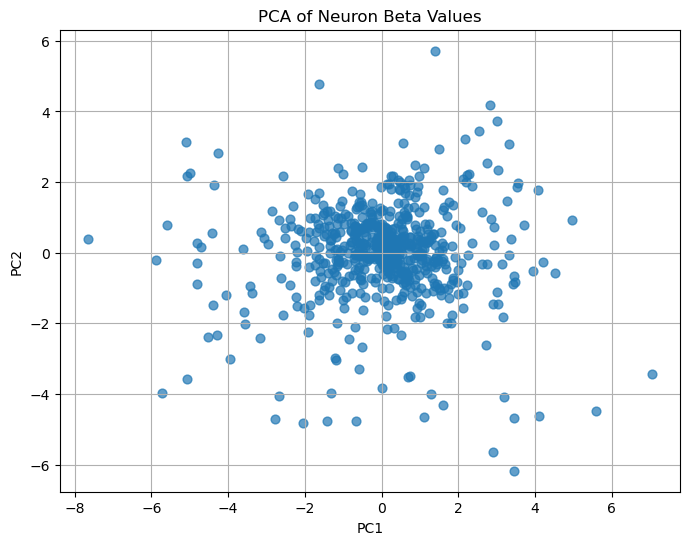

Explained variance ratio (PC1, PC2): [0.40939503 0.26980519]
PCA Loadings:
                         PC1       PC2
value_beta          0.272580  0.562194
state_1_beta        0.421270 -0.420290
state_2_beta       -0.382863 -0.359076
state_3_beta       -0.405984  0.133392
state_value_1_beta -0.398880  0.448681
state_value_2_beta  0.370376  0.392953
state_value_3_beta  0.374889 -0.069565


In [268]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Select the 8 beta columns for each neuron
beta_cols = [col for col in neuron_profile.columns if col.endswith('_beta')][1:] # Exclude the intercept
X_beta = neuron_profile[beta_cols].values

# Standardize the beta values
scaler = StandardScaler()
X_beta_scaled = scaler.fit_transform(X_beta)

# PCA to 2D for visualization
pca = PCA(n_components=2)
X_beta_pca = pca.fit_transform(X_beta_scaled)

# Plot the PCA result
plt.figure(figsize=(8, 6))
plt.scatter(X_beta_pca[:, 0], X_beta_pca[:, 1], s=40, alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Neuron Beta Values')
plt.grid(True)
plt.show()

# Show explained variance ratio for each principal component
print("Explained variance ratio (PC1, PC2):", pca.explained_variance_ratio_)

# Show PCA loadings (contribution of each beta to each PC)
loadings = pd.DataFrame(
    pca.components_.T,
    index=beta_cols,
    columns=['PC1', 'PC2']
)
print("PCA Loadings:")
print(loadings)

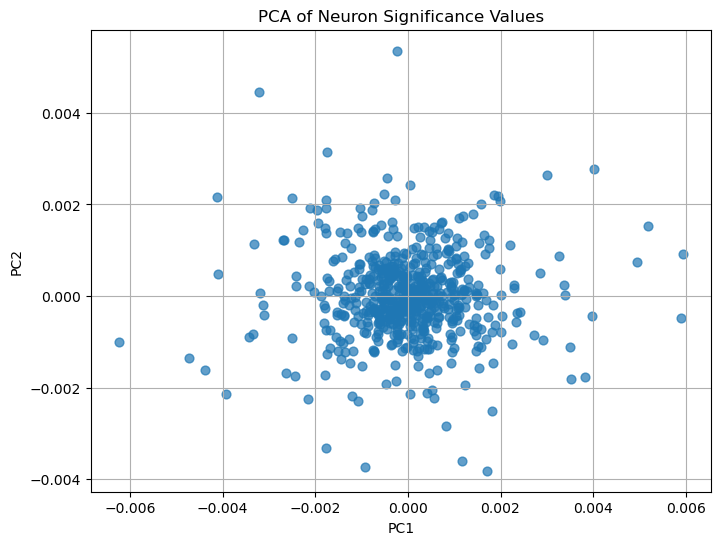

Explained variance ratio (PC1, PC2): [0.50981221 0.28793471]
PCA Loadings:
                         PC1       PC2
value_beta          0.053859 -0.021558
state_1_beta        0.710969 -0.118038
state_2_beta       -0.310188  0.782387
state_3_beta       -0.587110 -0.568311
state_value_1_beta -0.162465  0.037479
state_value_2_beta  0.086768 -0.183382
state_value_3_beta  0.129555  0.124346


In [269]:
def weighted_coeff(row):
    return {
        col: (1 - max(row[f'{col}_pval'], 0.99)) * row[f'{col}_beta']
        for col in tuning_cols
    }

weighted_df = neuron_profile.apply(weighted_coeff, axis=1, result_type='expand')

pca = PCA(n_components=2)
pca_scores = pca.fit_transform(weighted_df)

# Plot the PCA result
plt.figure(figsize=(8, 6))
plt.scatter(pca_scores[:, 0], pca_scores[:, 1], s=40, alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Neuron Significance Values')
plt.grid(True)
plt.show()

# Show explained variance ratio for each principal component
print("Explained variance ratio (PC1, PC2):", pca.explained_variance_ratio_)

# Show PCA loadings (contribution of each beta to each PC)
loadings = pd.DataFrame(
    pca.components_.T,
    index=beta_cols,
    columns=['PC1', 'PC2']
)

print("PCA Loadings:")
print(loadings)


In [ ]:
# Use the neuron_profile DataFrame and tuning_cls for coding classification
p_thresh = 0.05

# State coding: any state term is significant
state_coding = (
    (neuron_profile['state_1_pval'] < p_thresh) |
    (neuron_profile['state_2_pval'] < p_thresh) |
    (neuron_profile['state_3_pval'] < p_thresh)
)

# Value coding: value term is significant, but not state coding
val_coding = (neuron_profile['value_pval'] < p_thresh) & (~state_coding)

# state_value coding: any interaction term is significant, but not pure value coding
state_val_coding = (
    (neuron_profile['state_value_1_pval'] < p_thresh) |
    (neuron_profile['state_value_2_pval'] < p_thresh) |
    (neuron_profile['state_value_3_pval'] < p_thresh)
) & (~val_coding)

# Refine state coding: exclude neurons already classified as state_val_coding
state_coding = state_coding & (~state_val_coding)
 
neuron_profile['coding_type'] = 'none'  # default
neuron_profile.loc[state_coding, 'coding_type'] = 'state'
neuron_profile.loc[val_coding, 'coding_type'] = 'value'
neuron_profile.loc[state_val_coding, 'coding_type'] = 'state_value'

In [271]:
coding_counts = neuron_profile['coding_type'].value_counts()
print(coding_counts)

coding_type
state_value    250
none           186
value          119
state           51
Name: count, dtype: int64


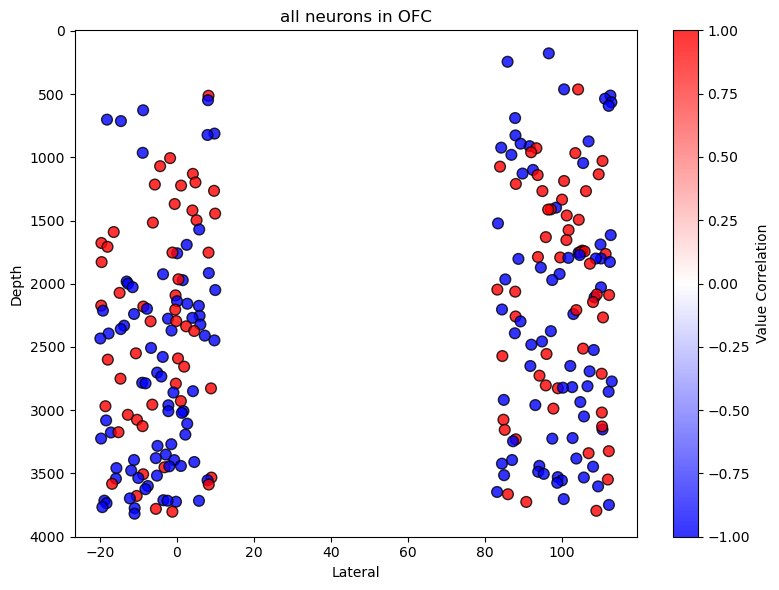

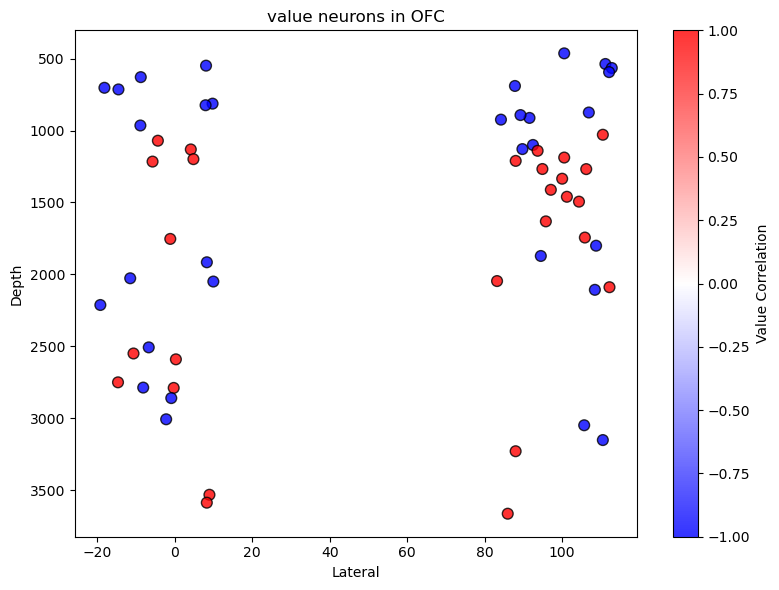

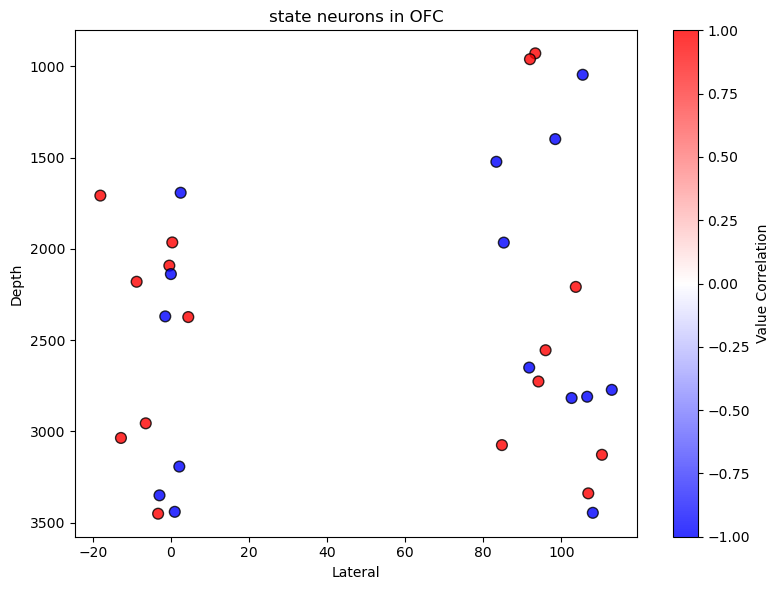

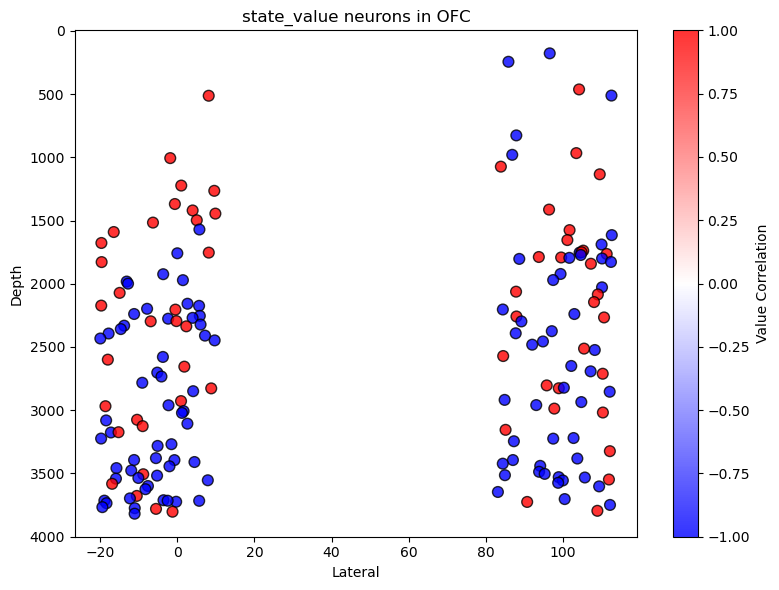

In [272]:
# Apply get_value_correlation to each row of valid_neurons to create a new column
neuron_profile['value_correlation'] = neuron_profile.apply(get_value_correlation, axis=1)
brain_area = 1  # '0' for CdN, '1' for OFC
brain_area_name = {1: 'OFC', 0: 'CdN'}[brain_area]

mask = ((neuron_profile['coding_type'] != 'none') & (neuron_profile['brain_area'] == brain_area))
all_neurons = neuron_profile[mask]
value_neurons = all_neurons[all_neurons['coding_type'] == 'value']
state_neurons = all_neurons[all_neurons['coding_type'] == 'state']
state_value_neurons = all_neurons[all_neurons['coding_type'] == 'state_value']

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    all_neurons['lateral'],
    all_neurons['depth'],
    c=all_neurons['value_correlation'],
    cmap='bwr',
    s=60,
    edgecolor='k',
    alpha=0.8
)
plt.title(f'all neurons in {brain_area_name}')
plt.xlabel('Lateral')
plt.ylabel('Depth')
plt.gca().invert_yaxis()
cbar = plt.colorbar(scatter, label='Value Correlation')
plt.tight_layout()

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    value_neurons['lateral'],
    value_neurons['depth'],
    c=value_neurons['value_correlation'],
    cmap='bwr',
    s=60,
    edgecolor='k',
    alpha=0.8
)
plt.title(f'value neurons in {brain_area_name}')
plt.xlabel('Lateral')
plt.ylabel('Depth')
plt.gca().invert_yaxis()
cbar = plt.colorbar(scatter, label='Value Correlation')
plt.tight_layout()

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    state_neurons['lateral'],
    state_neurons['depth'],
    c=state_neurons['value_correlation'],
    cmap='bwr',
    s=60,
    edgecolor='k',
    alpha=0.8
)
plt.title(f'state neurons in {brain_area_name}')
plt.xlabel('Lateral')
plt.ylabel('Depth')
plt.gca().invert_yaxis()
cbar = plt.colorbar(scatter, label='Value Correlation')
plt.tight_layout()

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    state_value_neurons['lateral'],
    state_value_neurons['depth'],
    c=state_value_neurons['value_correlation'],
    cmap='bwr',
    s=60,
    edgecolor='k',
    alpha=0.8
)
plt.xlabel('Lateral')
plt.ylabel('Depth')
plt.title(f'state_value neurons in {brain_area_name}')
plt.gca().invert_yaxis()
cbar = plt.colorbar(scatter, label='Value Correlation')
plt.tight_layout()
plt.show()

C:\Users\krgyk\AppData\Local\Temp\ipykernel_11896\767355449.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neurons2plot['rel_depth'] = neurons2plot['depth'] - target_depth
C:\Users\krgyk\AppData\Local\Temp\ipykernel_11896\767355449.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neurons2plot['depth_bin'] = pd.cut(neurons2plot['rel_depth'], bins=depth_bins)
C:\Users\krgyk\AppData\Local\Temp\ipykernel_11896\767355449.py:17: FutureWarning: The default of observed=False is deprecated and will be chang

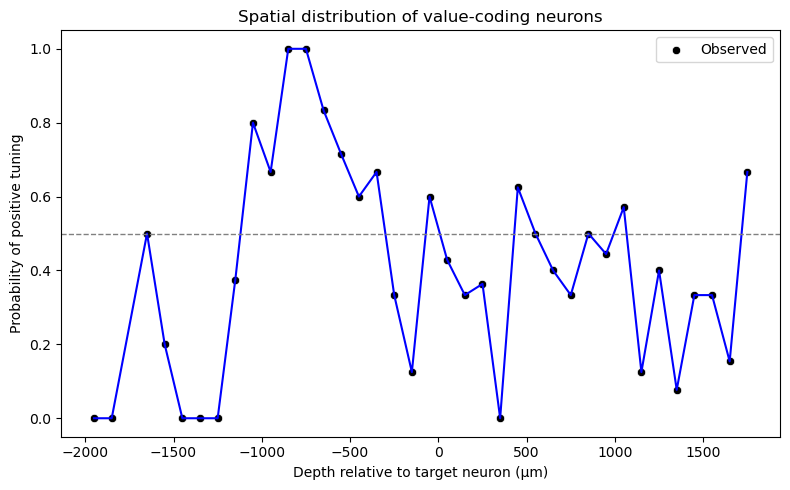

In [273]:
correlation2plot = 1  # 1 for positive, -1 for negative
brain_area = 1  # '0' for CdN, '1' for OFC
mask = (neuron_profile['coding_type'] != 'none') & (neuron_profile['brain_area'] == brain_area)
neurons2plot = neuron_profile[mask]

target_depth = neurons2plot[neurons2plot['value_correlation'] == correlation2plot]['depth'].median()
neurons2plot['rel_depth'] = neurons2plot['depth'] - target_depth

bin_width = 100
min_depth = neurons2plot['rel_depth'].min()
max_depth = neurons2plot['rel_depth'].max()
depth_bins = np.arange(np.floor(min_depth / bin_width) * bin_width,
                       np.ceil(max_depth / bin_width) * bin_width + bin_width,
                       bin_width)
neurons2plot['depth_bin'] = pd.cut(neurons2plot['rel_depth'], bins=depth_bins)

prob_by_bin = neurons2plot.groupby('depth_bin')['value_correlation'].apply(
    lambda x: (x == 1).mean()
)

# Convert bin labels to bin centers for plotting
bin_centers = [interval.mid for interval in prob_by_bin.index]

# Plot scatter + smooth curve
plt.figure(figsize=(8, 5))
sns.scatterplot(x=bin_centers, y=prob_by_bin.values, color='black', label='Observed')
sns.lineplot(x=bin_centers, y=prob_by_bin.values, color='blue')

plt.xlabel('Depth relative to target neuron (μm)')
plt.ylabel('Probability of positive tuning')
plt.title('Spatial distribution of value-coding neurons')
plt.axhline(0.5, color='gray', linestyle='--', linewidth=1)
plt.legend()
plt.tight_layout()
plt.show()

In [274]:
neurons2plot

,neuron,brain_area,lateral,depth,const_beta,value_beta,state_1_beta,state_2_beta,state_3_beta,state_value_1_beta,...,state_1_pval,state_2_pval,state_3_pval,state_value_1_pval,state_value_2_pval,state_value_3_pval,coding_type,value_correlation,rel_depth,depth_bin
274,b'D20231221_Rec06_OFC_u6',1,96.553494,178.081007,0.027108,-0.009915,0.072972,-0.064112,0.018249,-0.026551,...,4.841287e-02,7.290319e-02,5.980650e-01,0.017177,3.965876e-02,5.907457e-01,state_value,-1.0,-1913.505962,"(-2000.0, -1900.0]"
278,b'D20231221_Rec06_OFC_u15',1,85.848742,244.721917,0.049933,-0.017369,-0.095577,-0.002654,0.148164,0.019696,...,2.173617e-02,9.473775e-01,1.529210e-04,0.116114,9.786105e-01,2.612057e-03,state_value,-1.0,-1846.865051,"(-1900.0, -1800.0]"
288,b'D20231221_Rec06_OFC_u36',1,8.165361,513.327781,0.002597,0.002043,-0.162188,0.200238,-0.035454,0.061944,...,8.456259e-04,2.116612e-05,4.349571e-01,0.000024,9.740976e-04,3.742295e-01,state_value,1.0,-1578.259188,"(-1600.0, -1500.0]"
290,b'D20231221_Rec06_OFC_u38',1,100.524104,462.803306,0.088215,-0.027352,0.048732,0.002089,0.037395,-0.020855,...,3.525276e-01,9.671238e-01,4.465048e-01,0.186669,8.525509e-01,5.412864e-01,value,-1.0,-1628.783663,"(-1700.0, -1600.0]"
291,b'D20231221_Rec06_OFC_u40',1,104.161473,463.379499,-0.012159,0.002857,0.064458,-0.104349,0.027733,-0.020032,...,1.267600e-01,1.067657e-02,4.830797e-01,0.115163,4.263003e-02,8.471485e-01,state_value,1.0,-1628.207470,"(-1700.0, -1600.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,b'D20231221_Rec06_OFC_u552',1,-5.496392,3779.994035,-0.186877,0.051897,0.222193,-0.230574,-0.178496,-0.046257,...,3.813041e-12,1.037601e-13,2.326083e-09,0.000001,1.221769e-11,2.278001e-04,state_value,1.0,1688.407066,"(1600.0, 1700.0]"
602,b'D20231221_Rec06_OFC_u553',1,-11.007259,3774.414462,0.083698,-0.029720,-0.227801,-0.040623,0.352122,0.087221,...,5.581350e-04,5.231837e-01,1.516262e-08,0.000012,7.333537e-01,2.248590e-10,state_value,-1.0,1682.827493,"(1600.0, 1700.0]"
603,b'D20231221_Rec06_OFC_u554',1,108.905840,3795.349498,-0.000433,-0.008462,0.046638,-0.032476,-0.014595,-0.018330,...,2.732071e-01,4.300688e-01,7.143914e-01,0.152926,1.255403e-01,1.958772e-02,state_value,1.0,1703.762529,"(1700.0, 1800.0]"
604,b'D20231221_Rec06_OFC_u558',1,-11.037564,3818.250219,0.342372,-0.118304,0.189866,0.173665,-0.021159,-0.061124,...,6.506148e-06,1.978145e-05,5.897360e-01,0.000001,5.924558e-05,5.494696e-01,state_value,-1.0,1726.663250,"(1700.0, 1800.0]"


C:\Users\krgyk\AppData\Local\Temp\ipykernel_11896\1968870014.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prob_by_bin = neurons2plot.groupby('depth_bin')['value_correlation'].apply(
C:\Users\krgyk\AppData\Local\Temp\ipykernel_11896\1968870014.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prob_by_bin = neurons2plot.groupby('depth_bin')['value_correlation'].apply(
C:\Users\krgyk\AppData\Local\Temp\ipykernel_11896\1968870014.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or 

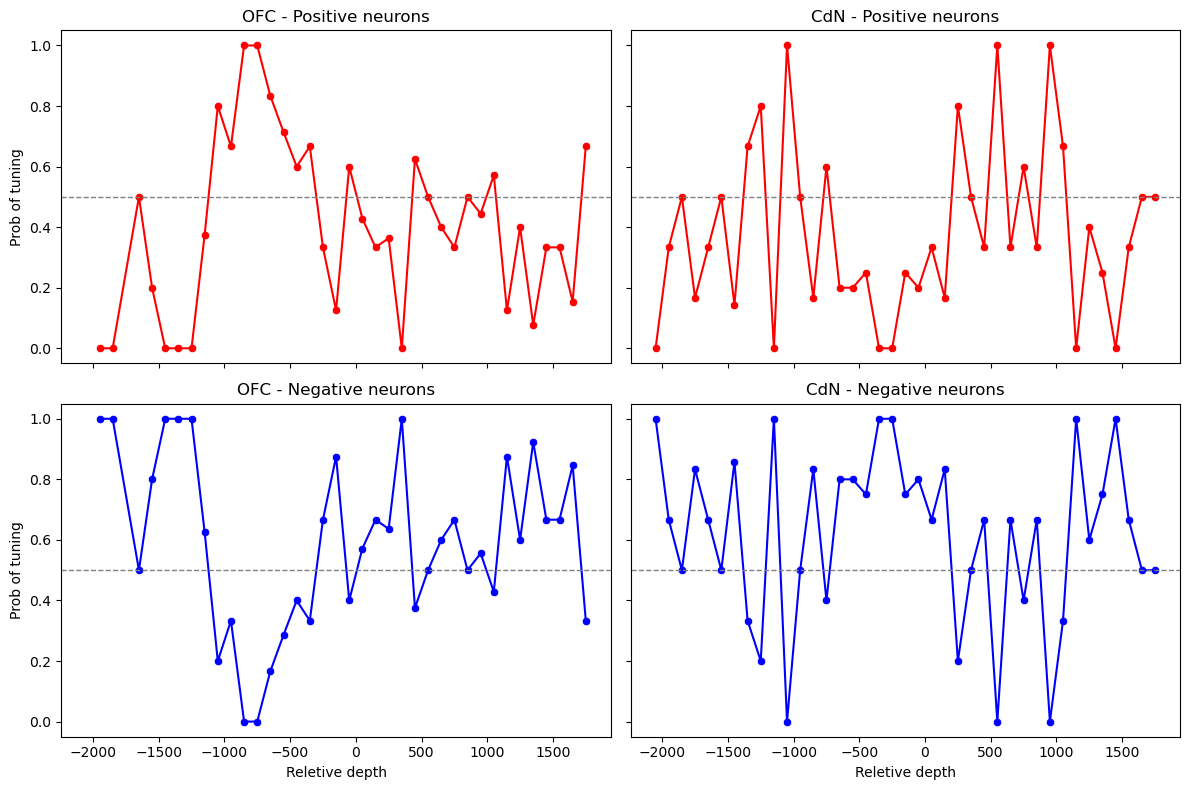

In [275]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
bin_width = 100

for i, brain_area in enumerate([1, 0]):  # OFC (left), CdN (right)
    for j, correlation2plot in enumerate([1, -1]):  # Positive (top), Negative (bottom)
        
        # Filter neurons
        mask = (neuron_profile['coding_type'] != 'none') & \
               (neuron_profile['brain_area'] == brain_area)
        neurons2plot = neuron_profile[mask].copy()
        
        # Select target depth
        target_depth = neurons2plot[neurons2plot['value_correlation'] == 1]['depth'].median()
        neurons2plot['rel_depth'] = neurons2plot['depth'] - target_depth

        # Bin depth
        min_depth = neurons2plot['rel_depth'].min()
        max_depth = neurons2plot['rel_depth'].max()
        depth_bins = np.arange(np.floor(min_depth / bin_width) * bin_width,
                                np.ceil(max_depth / bin_width) * bin_width + bin_width,
                                bin_width)
        neurons2plot['depth_bin'] = pd.cut(neurons2plot['rel_depth'], bins=depth_bins)

        # Compute probability
        prob_by_bin = neurons2plot.groupby('depth_bin')['value_correlation'].apply(
            lambda x: (x == correlation2plot).mean()
        )
        bin_centers = [interval.mid for interval in prob_by_bin.index]

        # Plot
        ax = axes[j, i]
        correlation_palette = {1: 'red', -1: 'blue'}
        color = correlation_palette[correlation2plot]  # select the color for this subplot
        sns.scatterplot(x=bin_centers, y=prob_by_bin.values, color=color, ax=ax)
        sns.lineplot(x=bin_centers, y=prob_by_bin.values, color=color, ax=ax)

        # Labels
        area_label = {0: 'CdN', 1: 'OFC'}[brain_area]
        corr_label = {-1: 'Negative', 1: 'Positive'}[correlation2plot]
        ax.set_title(f'{area_label} - {corr_label} neurons')
        ax.axhline(0.5, color='gray', linestyle='--', linewidth=1)
        ax.set_xlabel('Reletive depth')
        ax.set_ylabel('Prob of tuning')

plt.tight_layout()
plt.show()


In [276]:
datadir = r"D:\Projects\rotation_project\reprocessed_data"
data_files = find_h5_files(datadir)

all_neurons = []

for file_path in data_files:
    # Load session data
    firing_rates = np.concatenate([
        pull_from_h5(file_path, 'CdN_zFR'),
        pull_from_h5(file_path, 'OFC_zFR')
    ], axis=2)

    n_CdN = pull_from_h5(file_path, 'CdN_zFR').shape[2]
    n_OFC = pull_from_h5(file_path, 'OFC_zFR').shape[2]
    brain_areas = np.concatenate([
        np.zeros(n_CdN), np.ones(n_OFC)
    ]).astype(int)

    u_locations = np.concatenate([
        pull_from_h5(file_path, 'CdN_locations'),
        pull_from_h5(file_path, 'OFC_locations')
    ], axis=0)

    bhv = pd.read_hdf(file_path, key='bhv')
    ts = pull_from_h5(file_path, 'ts')

    if len(bhv) > len(firing_rates):
        bhv = bhv.iloc[:len(firing_rates)]

    trials2keep = (bhv['n_sacc'] > 0)
    bhv = bhv.loc[trials2keep]
    firing_rates = firing_rates[trials2keep, :, :]
    firing_rates = np.nan_to_num(firing_rates, nan=0)

    # Assume you already have a function to compute value_correlation per neuron
    # For now, mock it as random ±1
    value_correlation = np.random.choice([-1, 1], size=n_CdN + n_OFC)

    # Build session DataFrame
    session_df = pd.DataFrame({
        'depth': u_locations[:, 2],  # assuming depth is z-coordinate
        'brain_area': brain_areas,
        'value_correlation': value_correlation
    })

    # Compute rel_depth relative to median of positive neurons in this session
    target_depth = session_df[session_df['value_correlation'] == 1]['depth'].median()
    session_df['rel_depth'] = session_df['depth'] - target_depth

    all_neurons.append(session_df)

# Combine all sessions
combined_df = pd.concat(all_neurons, ignore_index=True)

# Bin rel_depth
bin_width = 100
min_depth = combined_df['rel_depth'].min()
max_depth = combined_df['rel_depth'].max()
depth_bins = np.arange(np.floor(min_depth / bin_width) * bin_width,
                       np.ceil(max_depth / bin_width) * bin_width + bin_width,
                       bin_width)
combined_df['depth_bin'] = pd.cut(combined_df['rel_depth'], bins=depth_bins)

# Compute probability of positive tuning per bin
prob_by_bin = combined_df.groupby('depth_bin')['value_correlation'].apply(
    lambda x: (x == 1).mean()
)
bin_centers = [interval.mid for interval in prob_by_bin.index]

# Plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=bin_centers, y=prob_by_bin.values, color='red', label='Positive tuning probability')
sns.lineplot(x=bin_centers, y=prob_by_bin.values, color='red')
plt.axhline(0.5, color='gray', linestyle='--', linewidth=1)
plt.xlabel('Depth relative to target neuron (μm)')
plt.ylabel('Probability of positive tuning')
plt.title('Spatial distribution across all sessions')
plt.tight_layout()
plt.show()


IndexError: index 2 is out of bounds for axis 1 with size 2

C:\Users\krgyk\AppData\Local\Temp\ipykernel_18168\2879355741.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pattern_counts.head(top_n), x='count', y='features_encoded', palette='mako')


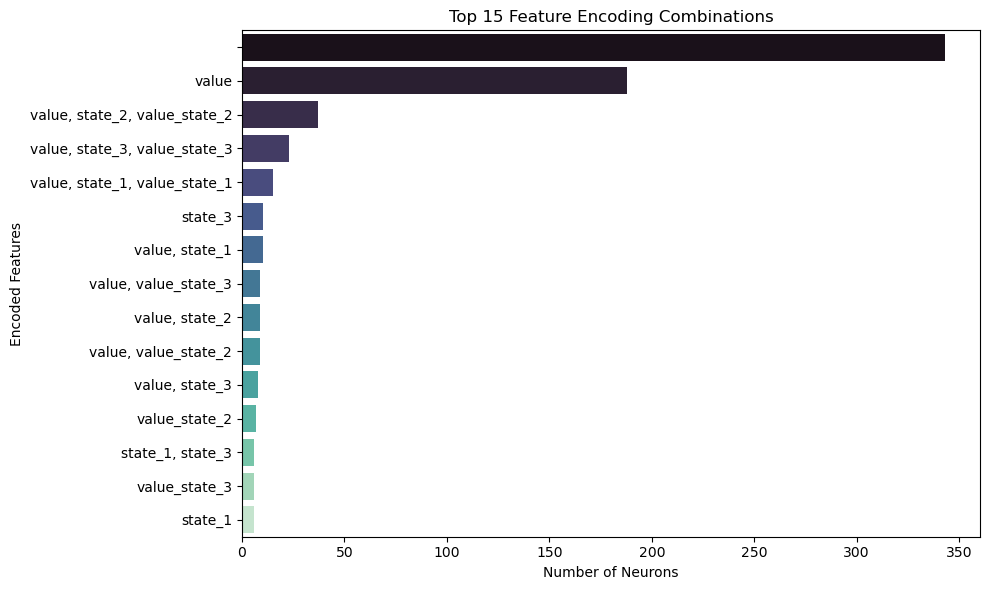

In [ ]:
# Step 1: Define p-value threshold
p_thresh = 0.01

# Step 2: Identify all p-value columns
pval_cols = [col for col in neuron_profile.columns if col.endswith('_pval')]

# Step 3: Create new tuning columns based on significance
for pval_col in pval_cols:
    feature_name = pval_col.replace('_pval', '_tuning')
    neuron_profile[feature_name] = (neuron_profile[pval_col] < p_thresh).astype(int)

# Select all tuning columns
tuning_cols = [col for col in neuron_profile.columns if col.endswith('_tuning')]
tuning_cols = tuning_cols[1:]

# Create label for each neuron's tuning pattern
neuron_profile['tuning_pattern'] = neuron_profile[tuning_cols].apply(
    lambda row: ','.join([col.replace('_tuning', '') for col in tuning_cols if row[col]]),
    axis=1
)
# Convert boolean matrix to string patterns
pattern_labels = neuron_profile[tuning_cols].apply(lambda row: ', '.join([col.replace('_tuning', '') for col in tuning_cols if row[col]]), axis=1)
pattern_counts = pattern_labels.value_counts().reset_index()
pattern_counts.columns = ['features_encoded', 'count']

top_n = 15
plt.figure(figsize=(10, 6))
sns.barplot(data=pattern_counts.head(top_n), x='count', y='features_encoded', palette='mako')
plt.xlabel('Number of Neurons')
plt.ylabel('Encoded Features')
plt.title(f'Top {top_n} Feature Encoding Combinations')
plt.tight_layout()
plt.show()


In [ ]:
# Count top patterns
top_patterns = neuron_profile['tuning_pattern'].value_counts().head(15).index.tolist()
top_patterns

['',
 'value',
 'value,state_2,value_state_2',
 'value,state_3,value_state_3',
 'value,state_1,value_state_1',
 'state_3',
 'value,state_1',
 'value,value_state_3',
 'value,state_2',
 'value,value_state_2',
 'value,state_3',
 'value_state_2',
 'state_1,state_3',
 'value_state_3',
 'state_1']

KeyError: '[587, 591, 592, 595, 609, 611, 613, 617, 619, 620, 621, 628, 634, 636, 639, 641, 643, 644, 652, 659, 661, 662, 667, 672, 675, 685, 688, 694, 701, 714, 715, 717, 723, 724, 725, 727, 728, 729, 747, 749, 750, 753, 754, 756, 759, 765, 768, 769, 771, 780, 782, 784, 788, 791, 794, 796, 799, 805, 810, 820, 821, 829] not in index'

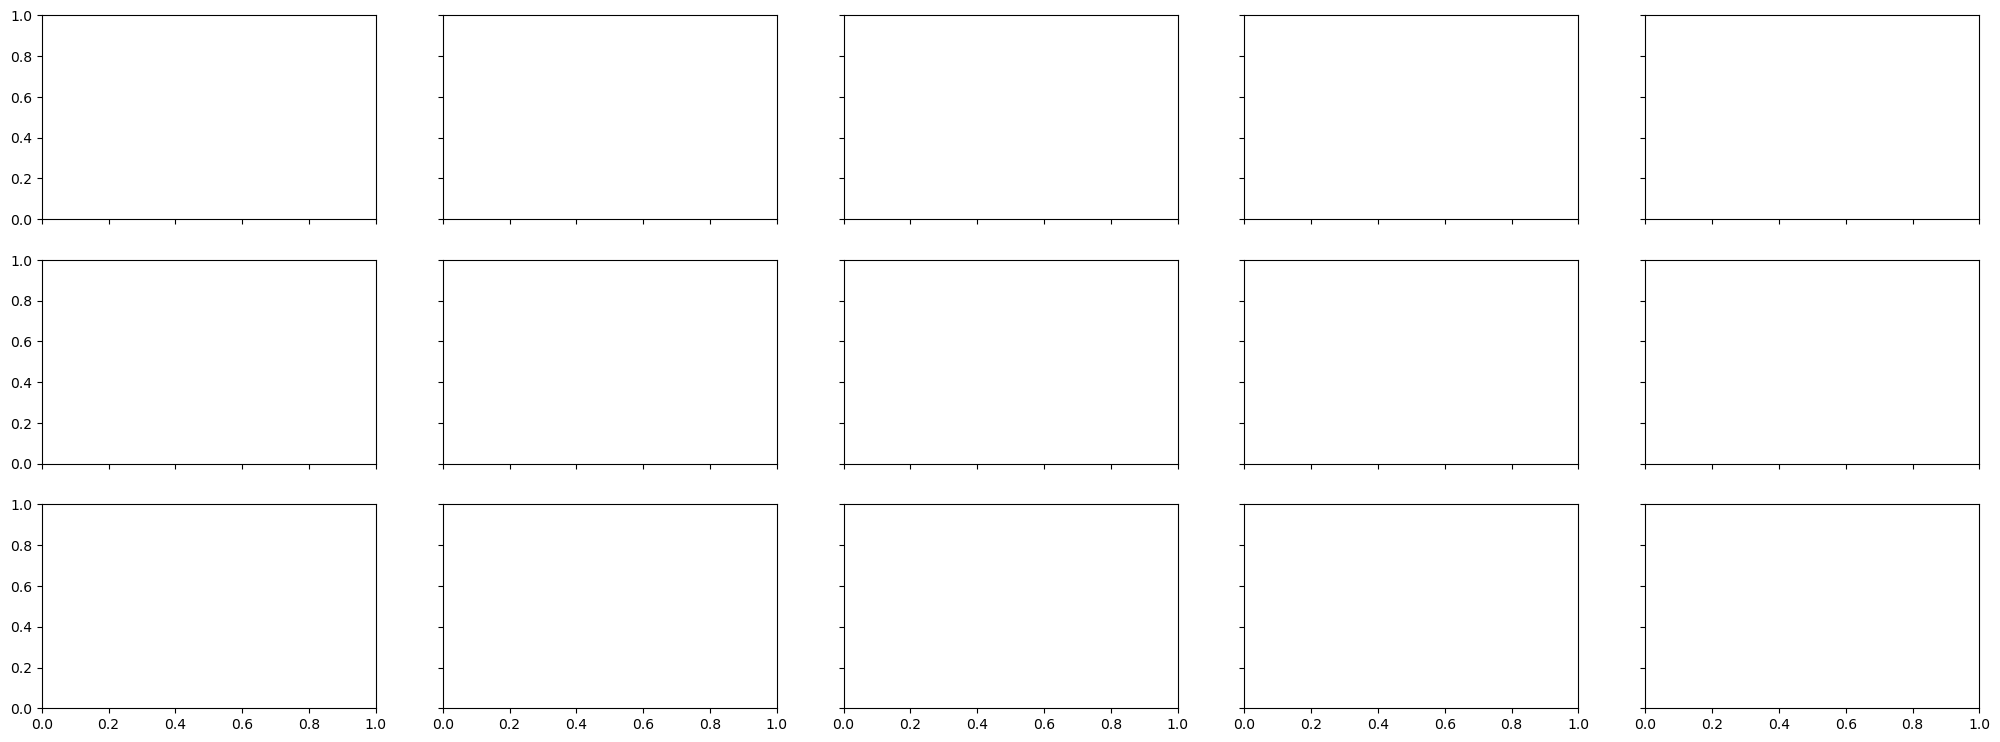

In [ ]:
# Dictionary: pattern → list of neuron indices
pattern_to_plot = 'value,state_2,state_value_2'
num_neurons = 5

pattern_neuron_indices = {
    pattern_to_plot: neuron_profile.index[neuron_profile['tuning_pattern'] == pattern_to_plot].tolist()
}

selected_neurons = random.sample(pattern_neuron_indices[pattern_to_plot], k=num_neurons)

mean_FR_profile = pd.DataFrame(mean_FR, columns=[i for i in range(mean_FR.shape[1])])

trial_info = trial_profile[['state', 'ch_val']].copy()

# Set up plot grid: 3 rows (states) × 10 columns (neurons)
fig, axes = plt.subplots(nrows=3, ncols=num_neurons, figsize=(25, 9), sharex=True, sharey=True)
state_order = sorted(trial_info['state'].unique())

for col_idx, neuron_id in enumerate(selected_neurons):
    for row_idx, state in enumerate(state_order):
        ax = axes[row_idx, col_idx]
        state_df = trial_profile[trial_profile['state'] == state]
        state_df['firing_rate'] = mean_FR_profile.loc[state_df.index, neuron_id]
        
        sns.scatterplot(
            data=state_df,
            x='ch_val',
            y='firing_rate',
            alpha=0.6,
            ax=ax,
            s=10
        )

        if row_idx == 0:
            ax.set_title(f'Neuron {neuron_id}', fontsize=10)
        if col_idx == 0:
            ax.set_ylabel(f'State {state}', fontsize=10)
        else:
            ax.set_ylabel('')
        ax.set_xlabel('')

# Global labels
fig.suptitle(f'Firing Rate vs Value for 10 {pattern_to_plot}-Tuned Neurons Across States', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
neuron_profile.shape, mean_FR.shape, trial_profile.shape

In [ ]:
neuron_profile.head()

In [ ]:
mask = (
    (neuron_profile['value_pval'] < p_thresh) &
    (
        (neuron_profile['state_1_pval'] < p_thresh) |
        (neuron_profile['state_2_pval'] < p_thresh) |
        (neuron_profile['state_3_pval'] < p_thresh)
    )
)

# Get indices of those neurons
dual_sig_indices = np.where(mask)[0]

# Extract firing rates for those neurons
firing = mean_FR[:, mask]  # shape: (n_trials, n_selected_neurons, n_timebins)

plt.plot(firing)
plt.title('Average Firing Rate of Value+State Tuned Neurons')
plt.xlabel('Time (bins)')
plt.ylabel('Firing Rate')
plt.show()

In [ ]:
# These are the p-value columns for each regressor
state_pvals = ['state_1_pval', 'state_2_pval', 'state_3_pval']
value_pval = 'value_pval'
interaction_pvals = ['state_value_1_pval', 'state_value_2_pval', 'state_value_3_pval']

# Threshold for significance
p_thresh = 0.01

# State coding: any state term is significant
state_coding = (
    (neuron_profile[state_pvals[0]] < p_thresh) |
    (neuron_profile[state_pvals[1]] < p_thresh) |
    (neuron_profile[state_pvals[2]] < p_thresh)
)

# Value coding: value term is significant, but not state coding
val_coding = (neuron_profile[value_pval] < p_thresh) & (~state_coding)

# State-dependent value coding: any interaction term is significant, but not pure value coding
state_val_coding = (
    (neuron_profile[interaction_pvals[0]] < p_thresh) |
    (neuron_profile[interaction_pvals[1]] < p_thresh) |
    (neuron_profile[interaction_pvals[2]] < p_thresh)
) & (~val_coding)

# Refine state coding: exclude neurons already classified as state_val_coding
state_coding = state_coding & (~state_val_coding)


In [ ]:
# define significance thresholds
sig_thresh = 0.05
beta_thresh = 1e-3  # to exclude near-zero betas

value_neurons = neuron_profile[
    (neuron_profile['value_pval'] < sig_thresh) &
    (neuron_profile['value_beta'].abs() > beta_thresh)
].copy()

# Use 1 for positive encoding, 0 for negative encoding
value_neurons['encoding_sign'] = (value_neurons['value_beta'] > 0).astype(int)


In [ ]:
neuron_profile.shape

In [ ]:
value_neurons.shape

In [ ]:
value_neurons.head()

In [ ]:
from matplotlib.patches import Patch


scatter = sns.scatterplot(
    data=value_neurons,
    x='lateral',
    y='depth',
    hue='encoding_sign',
    palette={1: 'red', 0: 'blue'},
    s=50,
    edgecolor='black'
)

plt.title('Spatial Distribution of Value-Encoding Neurons')
plt.xlabel('Lateral Position')
plt.ylabel('Depth')
plt.gca().invert_yaxis()  # optional: match anatomical orientation
plt.legend(title='Value Encoding')

legend_elements = [
    Patch(facecolor='red', edgecolor='black', label='Positive Neurons'),
    Patch(facecolor='blue', edgecolor='black', label='Negative Neurons')
]
plt.legend(handles=legend_elements, title='Value Encoding', loc='best')


plt.tight_layout()
plt.show()

In [ ]:
encoding_palette = {1: 'red', 0: 'blue'}

# Filter data by brain area
cdn_neurons = value_neurons[value_neurons['brain_area'] == 0]
ofc_neurons = value_neurons[value_neurons['brain_area'] == 1]

# Custom legend
legend_elements = [
    Patch(facecolor='red', edgecolor='black', label='Positive Neurons'),
    Patch(facecolor='blue', edgecolor='black', label='Negative Neurons')
]

# --- Plot for CdN ---
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=cdn_neurons,
    x='lateral',
    y='depth',
    hue='encoding_sign',
    palette=encoding_palette,
    s=100,
    edgecolor='black'
)
plt.gca().invert_yaxis()
plt.xlabel('Lateral Position')
plt.ylabel('Depth')
plt.title('CdN Value-Encoding Neurons')
plt.legend(handles=legend_elements, title='Value Encoding')
plt.tight_layout()
plt.show()

# --- Plot for OFC ---
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=ofc_neurons,
    x='lateral',
    y='depth',
    hue='encoding_sign',
    palette=encoding_palette,
    s=100,
    edgecolor='black'
)
plt.gca().invert_yaxis()
plt.xlabel('Lateral Position')
plt.ylabel('Depth')
plt.title('OFC Value-Encoding Neurons')
plt.legend(handles=legend_elements, title='Value Encoding')
plt.tight_layout()
plt.show()


In [ ]:
# Define your data directory and file list
datadir = r"D:\Projects\rotation_project\reprocessed_data"
data_files = find_h5_files(datadir)
data_files

In [ ]:
datadir = r"D:\Projects\rotation_project\reprocessed_data"
data_files = find_h5_files(datadir)